## Look Elsewhere Effect in 2-d

Kyle Cranmer, Nov 19, 2015

Based on
*Estimating the significance of a signal in a multi-dimensional search* by  Ofer Vitells and Eilam Gross http://arxiv.org/pdf/1105.4355v1.pdf

This is for the special case of a likelihood function of the form 
$L(\mu, \nu_1, \nu_2)$ where $\mu$ is a single parameter of interest and
$\nu_1,\nu_2$ are two nuisance parameters that are not identified under the null.
For example, $\mu$ is the signal strength of a new particle and $\nu_1,\nu_2$ are the
unknown mass and width of the new particle. Under the null hypothesis, those parameters 
don't mean anything... aka they "are not identified under the null" in the statistics jargon.
This introduces a 2-d look elsewhere effect.

The LEE correction in this case is based on 

\begin{equation}
E[ \phi(A_u) ] = P(\chi^2_1 > u) + e^{-u/2} (N_1 + \sqrt{u} N_2) \,
\end{equation}
where 
   * $A_u$ is the 'excursion set above level $u$ (eg. the set of parameter points in $(\nu_1,\nu_2)$ that have a -2 log-likelihood ratio greater than $u$ )
   * $\phi(A_u)$ is the Euler characteristic of the excursion set
   * $E[ \phi(A_u) ]$ is the expectation of the Euler characteristic of those excursion sets under the null
   * $P(\chi^2_1 > u)$ is the standard chi-square probability 
   * and $N_1$ and $N_2$ are two coefficients that characterize the chi-square random field.
   
### structure of the notebook

The notebook is broken into two parts.
  * calculation of $N_1$ and $N_2$ based on $E[ \phi(A_u) ]$ at two different levels $u_1$ and $u_2$
  * some code to calculate $\phi(A_u)$ using convolutional filters
  * some tests


In [72]:
%pylab inline --no-import-all
from scipy.optimize import fsolve
from scipy.stats import chi2
from numpy import exp, sqrt
from scipy.ndimage.morphology import *
from scipy.ndimage import *

Populating the interactive namespace from numpy and matplotlib


## Part 1: Calculate $N_1$ and $N_2$

In [236]:
def expectedEuler(u, n1, n2):
    return chi2.cdf(u, 1) + np.exp(-u/2)*(n1+n2*np.sqrt(u))

In [237]:
def equations(p,obs1, obs2,u1, u2):
    n1,n2 = p
    return (obs1-expectedEuler(u1,n1,n2), obs2-expectedEuler(u2,n1,n2))

In [238]:
# An example from the paper
n1, n2 = fsolve(equations, (1,1), args=(33.5, 94.6, 0., 1.))

print n1, n2

print equations((n1,n2),33.5, 94.6, 0., 1.)
#small difference wrt the paper, where n2 = 123

33.5 121.343467521
(0.0, -1.4210854715202004e-14)


## Part 2: Calculate Euler characteristic

In [239]:
def calculateEulerCharacteristic(a):
    face_filter=np.zeros((2,2))+1
    right_edge_filter = np.array([[1,1]])
    bottom_edge_filter = right_edge_filter.T
    
    n_faces = np.sum(convolve(a,face_filter,mode='constant')>3)
    n_edges = np.sum(convolve(a,right_edge_filter,mode='constant')>1)
    n_edges += np.sum(convolve(a,bottom_edge_filter,mode='constant')>1)
    n_vertices = np.sum(a>0)
    
    EulerCharacteristic = n_vertices-n_edges+n_faces
    print '%d-%d+%d=%d' %(n_vertices,n_edges,n_faces,EulerCharacteristic) 
    
    return n_vertices-n_edges+n_faces   

## Tests

### first, check $N_1$ and $N_2$ from the example in the paper

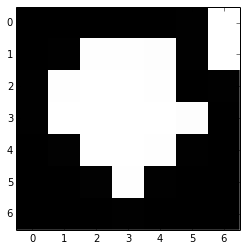

In [246]:
#create Fig 3 of http://arxiv.org/pdf/1105.4355v1.pdf
a = np.zeros((7,7))
a[1,2]=a[1,3]=a[2,1]=a[2,2]=a[2,3]=a[2,4]=1
a[3,1]=a[3,2]=a[3,3]=a[3,4]=a[3,5]=1
a[4,1]=a[4,2]=a[4,3]=a[4,4]=1
a[5,3]=1
a[6,0]=a[6,1]=1
a=a.T
plt.imshow(a,cmap='gray',interpolation='none')

In [248]:
#should be 2
calculateEulerCharacteristic(a) 

18-23+7=2


2

### Try a big matrix

In [271]:
#Fully filled, should be 1
randMatrix = np.zeros((100,100))+1
calculateEulerCharacteristic(randMatrix)

10000-19800+9801=1


1

9900-19501+9603=2


2

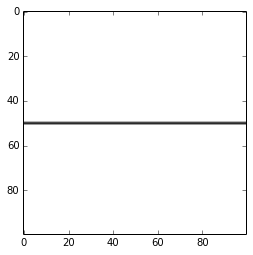

In [272]:
# split in half vertically, should be 2
randMatrix[50,:]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)

9702-18911+9215=6


6

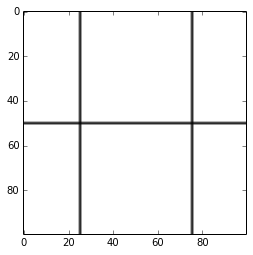

In [273]:
#split in half horizontally twice, should be 6
randMatrix[:,25]=0
randMatrix[:,75]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)

9687-18873+9191=5


5

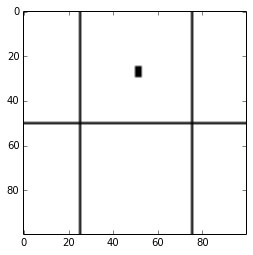

In [274]:
#remove a hole from middle of one, should be 5
randMatrix[25:30,50:53]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)